In [1]:
import sys 
sys.path.append("/home/jovyan/MoleculeSTM")
from MoleculeSTM.models.mega_molbart.mega_mol_bart import MegaMolBART
from model_zoo import MLP
import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm import tqdm
import math
from rdkit.Chem import AllChem, Descriptors
sys.path.append("/home/jovyan/prompts_learning/KPGT/src/data")
from featurizer import smiles_to_graph
import dgl
from KPGT.src.data.descriptors.rdNormalizedDescriptors import RDKit2DNormalized
st = torch.get_rng_state()
torch.set_rng_state(st)

def preprocess_batch_light(batch_num, batch_num_target, tensor_data):
    batch_num = np.concatenate([[0],batch_num],axis=-1)
    cs_num = np.cumsum(batch_num)
    add_factors = np.concatenate([[cs_num[i]]*batch_num_target[i] for i in range(len(cs_num)-1)], axis=-1)
    return tensor_data + torch.from_numpy(add_factors).reshape(-1,1)


vocab_path = "/home/jovyan/MoleculeSTM/MoleculeSTM/bart_vocab.txt"
MegaMolBART_generation_model_dir="/home/jovyan/MoleculeSTM/data/pretrained_MegaMolBART/checkpoints"
MegaMolBART_wrapper = MegaMolBART(vocab_path=vocab_path, input_dir=MegaMolBART_generation_model_dir, output_dir=None)
molecule_model = MegaMolBART_wrapper.model
print("Loading from pretrained MegaMolBART ({}).".format(MegaMolBART_generation_model_dir))
molecule_dim_generation = 256

device = "cuda" if torch.cuda.is_available() else "cpu"
from KPGT.src.data.featurizer import Vocab, N_BOND_TYPES, N_ATOM_TYPES
from KPGT.src.data.collator_tune import Collator_pretrain
from KPGT.src.model_config import config_dict
config = config_dict['base']
from pharmabench_pipeline import PharmaBenchDataset
from KPGT.src.data.featurizer import Vocab, N_BOND_TYPES, N_ATOM_TYPES
from KPGT.src.data.collator_tune import Collator_pretrain
from KPGT.src.model_config import config_dict
config = config_dict['base']

vocab = Vocab(N_ATOM_TYPES, N_BOND_TYPES)
collator = Collator_pretrain(vocab, max_length=config['path_length'], n_virtual_nodes=2, candi_rate=config['candi_rate'], fp_disturb_rate=config['fp_disturb_rate'], md_disturb_rate=config['md_disturb_rate'])

task_mode = "regression"
task_name = "logd_reg"
train_dataset = PharmaBenchDataset(task_name, mode="train")
from KPGT.src.model.light import LiGhTPredictor as LiGhT
kpgt = LiGhT(
        d_node_feats=config['d_node_feats'],
        d_edge_feats=config['d_edge_feats'],
        d_g_feats=config['d_g_feats'],
        d_fp_feats=train_dataset.d_fps,
        d_md_feats=train_dataset.d_mds,
        d_hpath_ratio=config['d_hpath_ratio'],
        n_mol_layers=config['n_mol_layers'],
        path_length=config['path_length'],
        n_heads=config['n_heads'],
        n_ffn_dense_layers=config['n_ffn_dense_layers'],
        input_drop=0.0,
        attn_drop=0.,
        feat_drop=0.,
        n_node_types=vocab.vocab_size
    )# .to("cuda")

from model_zoo import MMPL_Finetune_Model
model = MMPL_Finetune_Model(kpgt).to(device)
model.eval()

# ckpt = "/home/jovyan/prompts_learning/ft_weight/logd_reg_Epoch110_val_mae_0.40885_rmse_0.60321.pth"
# ckpt = "/home/jovyan/prompts_learning/ft_weight/ppb_reg_Epoch105_val_mae_0.07918_rmse_0.15615.pth"
# ckpt = "/home/jovyan/prompts_learning/ft_weight/cyp_3a4_reg_Epoch170_val_mae_7.85259_rmse_15.68281.pth"
ckpt = "/home/jovyan/prompts_learning/trained_weight/hum_mic_cl_reg_Epoch160_val_mae_0.34435_mse_0.4634.pth"
# ckpt = "/home/jovyan/prompts_learning/ft_weight/bbb_cls_Epoch4_val_auc_0.93345_acc_0.89513.pth"
# ckpt = "/home/jovyan/prompts_learning/ft_weight/water_sol_reg_Epoch102_val_mae_0.57307_rmse_0.86905.pth"
model.load_state_dict(torch.load(ckpt))

class MLP(nn.Module):
    def __init__(self, embed_dim=256, end=768):
        super().__init__()
        
        # self.fc1 = nn.Linear(embed_dim,end)
        # self.act = nn.GELU()
        # self.fc2 = nn.Linear(end, end)
        
        self.fc1 = nn.Linear(embed_dim,embed_dim*2)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(embed_dim*2, end)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x
    
def mean_pooling(token_embeddings, attention_mask):
    attention_mask = ~attention_mask
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float() # [pad, B, d]
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 0) # [B, d]
    sum_mask = torch.clamp(input_mask_expanded.sum(0), min=1e-9) # [B, d]
    return sum_embeddings / sum_mask


generation2MMPL = MLP(molecule_dim_generation, 768).to(device)
# generation2MMPL = nn.Linear(molecule_dim_generation, 768).to(device)



import numpy as np
from multiprocessing import Pool
from rdkit import Chem
from scipy import sparse as sp
def preprocess_smi_for_kpgt(smiles, n_jobs=1):
    print('extracting fingerprints')
    FP_list = []
    mol = Chem.MolFromSmiles(smiles)
    FP_list.append(list(Chem.RDKFingerprint(mol, minPath=1, maxPath=7, fpSize=512)))
    FP_arr = np.array(FP_list)
    fp = sp.csc_matrix(FP_arr)
    print('finish fingerprints')

    print('extracting molecular descriptors')
    generator = RDKit2DNormalized()
    features_map = Pool(n_jobs).imap(generator.process, [smiles])
    arr = np.array(list(features_map))
    md = arr[:,1:]
    return fp, md

def clip_loss_for_edit(molecule_repr, text_repr):
    molecule_repr = F.normalize(molecule_repr, dim=-1)
    text_repr = F.normalize(text_repr, dim=-1)

    similarity = -torch.mm(molecule_repr, text_repr.transpose(0, 1))[0]
    return similarity


def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)
    return initial_lr * lr_ramp

def evaluate_SMILES_list(SMILES_list, description):
    print("SMILES_list:", SMILES_list)
    mol_list = []
    for SMILES in SMILES_list:
        mol = Chem.MolFromSmiles(SMILES)
        if mol is None:
            continue
        mol_list.append(mol)

    if len(mol_list) < 3:
        return [False]

    if "soluble" in description and "insoluble" not in description:
        props = ["MolLogP"]
        prop_pred = [(n, func) for n, func in Descriptors.descList if n.split("_")[-1] in props]
        print(prop_pred)
        value_list = []
        for name, func in prop_pred:
            for idx, (SMILES, mol) in enumerate(zip(SMILES_list, mol_list)):
                if idx == 1:
                    continue
                value = func(mol)
                value_list.append(value)
                print("SMILES: {}\t\t\tlogP: {:.5f}".format(SMILES, value))
        if value_list[0] > value_list[-1]:
            answer = [True]
        else:
            answer = [False]

    return answer





/home/jovyan/.conda/fcb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-04-17 04:16:49,576] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/jovyan/.conda/fcb/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/jovyan/.conda/fcb/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/jovyan/.conda/fcb/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


using world size: 1 and model-parallel size: 1 
using torch.float32 for parameters ...
-------------------- arguments --------------------
  adam_beta1 ...................... 0.9
  adam_beta2 ...................... 0.999
  adam_eps ........................ 1e-08
  adlr_autoresume ................. False
  adlr_autoresume_interval ........ 1000
  apply_query_key_layer_scaling ... False
  apply_residual_connection_post_layernorm  False
  attention_dropout ............... 0.1
  attention_softmax_in_fp32 ....... False
  batch_size ...................... None
  bert_load ....................... None
  bias_dropout_fusion ............. False
  bias_gelu_fusion ................ False
  block_data_path ................. None
  checkpoint_activations .......... False
  checkpoint_in_cpu ............... False
  checkpoint_num_layers ........... 1
  clip_grad ....................... 1.0
  contigious_checkpointing ........ False
  cpu_optimizer ................... False
  cpu_torch_adam ..........

In [2]:
text = "This molecule is soluble in water."
text_repr = model.text_proc.edit_forward(text)
SMILES="Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1"
# SMILES="OC[C@H]1O[C@@H](n2cnc3c(NC4CCCC4)nc(Cl)nc32)[C@H](O)[C@@H]1O"
fps, mds = preprocess_smi_for_kpgt(SMILES)
fps = torch.from_numpy(fps.todense().astype(np.float32))
mds = torch.from_numpy(np.where(np.isnan(mds.astype(np.float32)), 0, mds))
graphs = smiles_to_graph(SMILES, vocab, max_length=config['path_length'], n_virtual_nodes=2, add_self_loop=True)
batched_graph = dgl.batch([graphs])
mds = torch.stack([mds], dim=0).reshape(len([SMILES]),-1).float()
fps = torch.stack([fps], dim=0).reshape(len([SMILES]),-1).float()
batched_graph.edata['path'][:, :] = preprocess_batch_light(batched_graph.batch_num_nodes(), batched_graph.batch_num_edges(), batched_graph.edata['path'][:, :])
batched_graph = batched_graph.to(device)
mmpl_repre = model.mol_encoder.edit_forward([batched_graph, fps.cuda(), mds.cuda()])
    
first_and_second_SMILES_list = []

latent_code_init, pad_mask_init = MegaMolBART_wrapper.smileslist2embedding([SMILES])  # [pad, B, d], [pad, B]
first_and_second_SMILES_list.append(SMILES)

regenerated_mols = MegaMolBART_wrapper.inverse_transform([latent_code_init], pad_mask_init.bool().cuda(), k=1, sanitize=True)
first_and_second_SMILES_list.append(regenerated_mols[0])

# l2_lambda_list = [0.]
# l2_lambda_list = [0.1, 0.01, 1e-3, 1e-4, 1e-5, 1e-6, 0.]
l2_lambda_list = [0.001, 0.001, 1e-3, 1e-4, 1e-5, 0, 0, 0, 0 ,0]
# l2_lambda_list = [0, 0, 0, 1e-7, 1e-6, 1e-5, 1e-4, 0., 0.]
# l2_lambda_list = [1e-4, 1e-4, 1e-4, 1e-4,1e-4]
# l2_lambda_list = [1e-3, 1e-4, 1e-5, 1e-6, 1e-8]
result_SMILES_list_one_pair, result_eval_list_one_pair = [], []

use_noise_for_init = True
# use_noise_for_init = False
verbose = True
epochs = 10
# normalize = True
normalize = False
wd = 0.
lr = 7e-5

# seed = 10
# seed = 1024
# # seed = 979
# torch.manual_seed(seed)
# np.random.seed(seed)
# torch.cuda.manual_seed(seed)

if use_noise_for_init:
    print("Use random noise for init")
    random_noise = torch.randn(latent_code_init.size()).to(device)

for l2_lambda in l2_lambda_list:
    print("l2 lambda: {}".format(l2_lambda))
    current_SMILES_list = [first_and_second_SMILES_list[0]] + [first_and_second_SMILES_list[1]]
    if use_noise_for_init:
        print("Use random noise for init")
        # random_noise = torch.randn(latent_code_init.size()).to(device)
        latent = latent_code_init.detach().clone() + random_noise * 0.1
    else:
        print("No random noise for init")
        latent = latent_code_init.detach().clone()
    pad_mask = pad_mask_init.detach().clone()
    latent.requires_grad = True
    print("Learning rate of latent: {}".format(lr))
    model_params = [
        {'params': latent, 'lr': lr, "weight_decay": wd},
        {'params': generation2MMPL.parameters(), 'lr': 7e-5, "weight_decay": 0.},
    ]
    from adan import Adan
    optimizer = Adan(model_params, betas=(0.98, 0.92, 0.99), max_grad_norm=5.)
    # optimizer = Adan(model_params, betas=(0.97, 0.92, 0.95), max_grad_norm=5.)

    if verbose:
        L = tqdm(range(epochs))
    else:
        L = range(epochs)

    for i in L:
        t = i / epochs
        # lr = get_lr(t, lr)
        lr = lr * 0.99
        optimizer.param_groups[0]["lr"] = lr
        # optimizer.param_groups[1]["lr"] = lr

        molecule_repr_generation = mean_pooling(latent, pad_mask) # [B, d]
        if normalize:
            molecule_repr_generation = F.normalize(molecule_repr_generation, dim=-1)
        molecule_repr_foundation = generation2MMPL(molecule_repr_generation)

        clip_loss_ = clip_loss_for_edit(molecule_repr_foundation, text_repr)
        l2_loss_ = -l2_lambda * ((latent_code_init - latent) ** 2).mean()
        align_loss_ = ((molecule_repr_foundation - mmpl_repre) ** 2).mean()
        # align_loss_ = clip_loss_for_edit(molecule_repr_foundation, mmpl_repre)

        loss = .1 * clip_loss_ + .01 *l2_loss_ + .2 *align_loss_

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    print("clip loss: {:.5f}\tL2 loss: {:.5f}\tAlign loss: {:.5f}".format(clip_loss_.item(), l2_loss_.item(), align_loss_.item()))

    generated_mols = MegaMolBART_wrapper.inverse_transform([latent], pad_mask.bool().cuda(), k=1, sanitize=True)
    current_SMILES_list.append(generated_mols[0])
    result_SMILES_list_one_pair.append([text] + current_SMILES_list + ['{}'.format(l2_lambda)])

    current_result_list = evaluate_SMILES_list(current_SMILES_list, text)
    result_eval_list_one_pair.append(current_result_list)
    print()

result_eval_list_one_pair = np.array(result_eval_list_one_pair)
result_eval_list_one_pair = np.any(result_eval_list_one_pair, axis=0, keepdims=True)

extracting fingerprints
finish fingerprints
extracting molecular descriptors


Use random noise for init
l2 lambda: 0.001
Use random noise for init
Learning rate of latent: 7e-05


100%|██████████| 10/10 [00:00<00:00, 23.55it/s]


clip loss: -0.45579	L2 loss: -0.00001	Align loss: 0.06545


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'Cn1cc(-c2n[nH]c3cc(NCc4cc(F)ccc4S(C)(=O)=O)ccc23)cn1']
[('MolLogP', <function <lambda> at 0x7fdb1e99fc10>)]
SMILES: Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1			logP: 3.11810
SMILES: Cn1cc(-c2n[nH]c3cc(NCc4cc(F)ccc4S(C)(=O)=O)ccc23)cn1			logP: 3.11810

l2 lambda: 0.001
Use random noise for init
Learning rate of latent: 6.33067452506163e-05


100%|██████████| 10/10 [00:00<00:00, 29.99it/s]


clip loss: -0.79103	L2 loss: -0.00001	Align loss: 0.06267


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'c1c(-c2cnn(C)c2)n[nH]c2)c1cc(NCc1c(S(=O)(C)=O)ccc(F)c12']

l2 lambda: 0.001
Use random noise for init
Learning rate of latent: 5.725348563180614e-05


100%|██████████| 10/10 [00:00<00:00, 30.25it/s]


clip loss: -0.95454	L2 loss: -0.00001	Align loss: 0.06142


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'Cn1cc(-c2cc(NCc3cc(F)ccc3S(C)(=O)=O)cc3n[nH]cc23)cn1']
[('MolLogP', <function <lambda> at 0x7fdb1e99fc10>)]
SMILES: Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1			logP: 3.11810
SMILES: Cn1cc(-c2cc(NCc3cc(F)ccc3S(C)(=O)=O)cc3n[nH]cc23)cn1			logP: 3.11810

l2 lambda: 0.0001
Use random noise for init
Learning rate of latent: 5.1779026137179606e-05


100%|██████████| 10/10 [00:00<00:00, 25.60it/s]


clip loss: -0.99692	L2 loss: -0.00000	Align loss: 0.06100


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1']
[('MolLogP', <function <lambda> at 0x7fdb1e99fc10>)]
SMILES: Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1			logP: 3.11810
SMILES: Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1			logP: 3.11810

l2 lambda: 1e-05
Use random noise for init
Learning rate of latent: 4.682802309987761e-05


100%|██████████| 10/10 [00:00<00:00, 31.50it/s]


clip loss: -0.99830	L2 loss: -0.00000	Align loss: 0.06104


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'Cn1nncc1-c1n[nH]c2cc(NCc3cc(F)ccc3S(C)(=O)=O)ccc12']
[('MolLogP', <function <lambda> at 0x7fdb1e99fc10>)]
SMILES: Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1			logP: 3.11810
SMILES: Cn1nncc1-c1n[nH]c2cc(NCc3cc(F)ccc3S(C)(=O)=O)ccc12			logP: 2.51310

l2 lambda: 0
Use random noise for init
Learning rate of latent: 4.235042469962754e-05


100%|██████████| 10/10 [00:00<00:00, 30.86it/s]


clip loss: -0.99834	L2 loss: 0.00000	Align loss: 0.06106


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'c1c(-c2cnn(C)c2)[nH]c2c1cc(NCc1cc(F)ccc1S(=O)(C)=O)c2']

l2 lambda: 0
Use random noise for init
Learning rate of latent: 3.830096496735328e-05


100%|██████████| 10/10 [00:00<00:00, 30.99it/s]


clip loss: -0.99838	L2 loss: 0.00000	Align loss: 0.06107


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'Cn1cc(-c2n[nH]c3cc(NCc4cc(F)ccc4S(C)(=O)=O)ccc23)cn1']
[('MolLogP', <function <lambda> at 0x7fdb1e99fc10>)]
SMILES: Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1			logP: 3.11810
SMILES: Cn1cc(-c2n[nH]c3cc(NCc4cc(F)ccc4S(C)(=O)=O)ccc23)cn1			logP: 3.11810

l2 lambda: 0
Use random noise for init
Learning rate of latent: 3.463870617201448e-05


100%|██████████| 10/10 [00:00<00:00, 29.76it/s]


clip loss: -0.99837	L2 loss: 0.00000	Align loss: 0.06106


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'Cn1cc(-c2n[nH]c3cc(NCc4ccc(F)cc4S(C)(=O)=O)ccc23)cn1']
[('MolLogP', <function <lambda> at 0x7fdb1e99fc10>)]
SMILES: Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1			logP: 3.11810
SMILES: Cn1cc(-c2n[nH]c3cc(NCc4ccc(F)cc4S(C)(=O)=O)ccc23)cn1			logP: 3.11810

l2 lambda: 0
Use random noise for init
Learning rate of latent: 3.1326624963466745e-05


100%|██████████| 10/10 [00:00<00:00, 29.93it/s]


clip loss: -0.99839	L2 loss: 0.00000	Align loss: 0.06107


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'Cn1nncc1-c1n[nH]c2cc(NCc3ccc(F)cc3S(C)(=O)=O)ccc12']
[('MolLogP', <function <lambda> at 0x7fdb1e99fc10>)]
SMILES: Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1			logP: 3.11810
SMILES: Cn1nncc1-c1n[nH]c2cc(NCc3ccc(F)cc3S(C)(=O)=O)ccc12			logP: 2.51310

l2 lambda: 0
Use random noise for init
Learning rate of latent: 2.833123808748267e-05


100%|██████████| 10/10 [00:00<00:00, 31.56it/s]


clip loss: -0.99839	L2 loss: 0.00000	Align loss: 0.06107


SMILES_list: ['Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1', 'Cn1cc(-c2cc(-c3ccc4cc(F)cc(CNS(C)(=O)=O)c4c3)[nH]n2)cn1', 'c1c(-c2cnn(C)c2)n[nH]c1-c1cc2c(cc(F)c1)S(=O)(=O)C)ccc2']



In [3]:
from rdkit import Chem
ori_smi = SMILES
edi_smi = "CC(C)(Nc1ncc(C(=O)N2CCC3(CCOCC3)C2)cn1)c1cncnc1"
print(ori_smi)
print(edi_smi)

Cn1cc(-c2n[nH]c3ccc(NCc4cc(F)ccc4S(C)(=O)=O)cc23)cn1
CC(C)(Nc1ncc(C(=O)N2CCC3(CCOCC3)C2)cn1)c1cncnc1


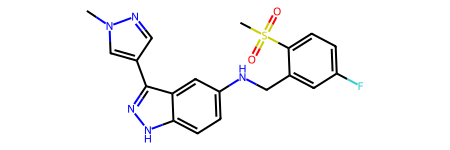

In [4]:
Chem.MolFromSmiles(ori_smi)

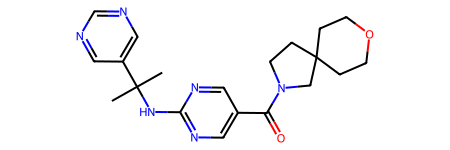

In [5]:
Chem.MolFromSmiles(edi_smi)

In [108]:
# SMILES=ori_smi
fps, mds = preprocess_smi_for_kpgt(ori_smi)
fps = torch.from_numpy(fps.todense().astype(np.float32))
mds = torch.from_numpy(np.where(np.isnan(mds.astype(np.float32)), 0, mds))
graphs = smiles_to_graph(ori_smi, vocab, max_length=config['path_length'], n_virtual_nodes=2, add_self_loop=True)
batched_graph = dgl.batch([graphs])
mds = torch.stack([mds], dim=0).reshape(len([ori_smi]),-1).float()
fps = torch.stack([fps], dim=0).reshape(len([ori_smi]),-1).float()
batched_graph.edata['path'][:, :] = preprocess_batch_light(batched_graph.batch_num_nodes(), batched_graph.batch_num_edges(), batched_graph.edata['path'][:, :])
batched_graph = batched_graph.to(device)
model.eval()

with torch.no_grad():
    pred = model([batched_graph, fps.cuda(), mds.cuda()])
    max_v, min_v =6.361727836017593, -2.5228787452803374
    ori_hum_mic = (pred + 1.) / 2. * (max_v - min_v) + min_v
    
    
# SMILES=edi_smi
fps, mds = preprocess_smi_for_kpgt(edi_smi)
fps = torch.from_numpy(fps.todense().astype(np.float32))
mds = torch.from_numpy(np.where(np.isnan(mds.astype(np.float32)), 0, mds))
graphs = smiles_to_graph(edi_smi, vocab, max_length=config['path_length'], n_virtual_nodes=2, add_self_loop=True)
batched_graph = dgl.batch([graphs])
mds = torch.stack([mds], dim=0).reshape(len([edi_smi]),-1).float()
fps = torch.stack([fps], dim=0).reshape(len([edi_smi]),-1).float()
batched_graph.edata['path'][:, :] = preprocess_batch_light(batched_graph.batch_num_nodes(), batched_graph.batch_num_edges(), batched_graph.edata['path'][:, :])
batched_graph = batched_graph.to(device)

with torch.no_grad():
    pred = model([batched_graph, fps.cuda(), mds.cuda()])
    max_v, min_v = 6.361727836017593, -2.5228787452803374
    edi_hum_mic = (pred + 1.) / 2. * (max_v - min_v) + min_v
print()
print("Original: ", ori_hum_mic[0, 0].cpu().numpy())
print("After edit: ", edi_hum_mic[0, 0].cpu().numpy())

extracting fingerprints
finish fingerprints
extracting molecular descriptors
extracting fingerprints
finish fingerprints
extracting molecular descriptors

Original:  2.1445785
After edit:  2.0274372
